# Estimating Pillar Volume
---
**Author**: Ryan Lane  
**Date**: 3 July 2023

#### Overview
All of the volume measurements have been made. Now making plots of various relationships involving dose and volume.

In [1]:
# indirectly enable autocomplete
%config Completer.use_jedi = False

# autoreload modules
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Organize data
---

Merge the volume measurements with Cristiano's logs/records of the applied dose. In the end, each row will correspond to one pillar. This already matches with the arrangement of the output of the volume measurements (`results.csv`).

Couple other things to make life easier
1) Forget "cone" and "cylinder" measurements -- highly convenient because then there is only one measurement per pillar / per row.
2) Assume sorting pillars by height corresponds to Cristiano's 1-9 ordering for the pillars.
3) Some images don't have 9 proper pillars.
    * Sometimes the 2nd pillar is clipped by some weird, out-of-focus cone thingy.
    * Sometimes the 1st pillar is weird and either covers other pillars or is just too f'ed up.
    * In all of ^^ these cases ^^ we rely on _a priori_ information.

#### Curate measurement results

In [3]:
# Read csv of analyzed volume measurements
fp = Path("../results/results.csv")
df = pd.read_csv(fp)

# Only keep pillar measurement
df_vol = df.loc[df["method"] == "pillar"]
df_vol.head()

,filename,pillar #,method,width (nm),height (nm),volume (nm^3),error height (nm),error volume (nm^3)
2,A3_50g1T_001,1.0,pillar,67.44800,290.592902,7.893852e+05,3.815508,83062.368168
5,A3_50g1T_001,2.0,pillar,64.75008,360.621061,1.006286e+06,3.815508,98955.782110
8,A3_50g1T_001,3.0,pillar,67.44800,450.844245,1.312116e+06,3.815508,128867.999228
11,A3_50g1T_001,4.0,pillar,67.44800,553.862966,1.638514e+06,3.815508,158314.503049
14,A3_50g1T_001,5.0,pillar,67.44800,679.774736,2.012551e+06,3.815508,194304.686520


#### Curate dose calculations

In [4]:
# Read xlsx of dose calculations
fp = Path("../doses_and_mimosas.csv")
df_log = pd.read_csv(fp, header=[0, 1])

# Melt DataFrame into long format such that each row corresponds to one pillar
df_log = pd.melt(
    df_log,
    id_vars=["filename", "material", "ID", "code", "notes", "energy (kV)", "current (nA)"],
    value_vars=["1", "2", "3", "4", "5", "6", "7", "8", "9"],
    var_name="pillar #",
    value_name="dwell (s)",
    col_level=1,
    ignore_index=True
).dropna()

# Convert data types to numeric
df_log["current (nA)"] = pd.to_numeric(df_log["current (nA)"])
df_log["dwell (s)"] = pd.to_numeric(df_log["dwell (s)"])
df_log["pillar #"] = pd.to_numeric(df_log["pillar #"])

# Calculate dose -- copy Cristiano's calculation
df_log["dose (uC)"] = 1e-3 * df_log["current (nA)"] * df_log["dwell (s)"]
df_log["dose (10e4 e-)"] = df_log["dose (uC)"] / 1.60217e-9

# Preview dose calculations
df_log.head()

,filename,material,ID,code,notes,energy (kV),current (nA),pillar #,dwell (s),dose (uC),dose (10e4 e-)
0,D1_49a1T_001,W,49,a,im,5,0.041,1,1.0,0.000041,25590.293165
1,D1_49b1T_001,W,49,b,im,5,0.330,1,1.0,0.000330,205970.652303
2,D1_49c1T_001,W,49,c,im,5,1.330,1,1.0,0.001330,830124.144130
4,B1_52a1T,W,52,a,im,20,0.041,1,1.0,0.000041,25590.293165
5,B1_52b1T,W,52,b,im,20,0.330,1,1.0,0.000330,205970.652303


#### Merge

In [5]:
# Merge baby merge
df = pd.merge(
    left=df_vol,
    right=df_log,
    how="outer",
    on=["filename", "pillar #"],
).dropna(
).sort_values([
    "material",
    "energy (kV)",
    "current (nA)"
])

# Preview merged dataset
df.head(10)

,filename,pillar #,method,width (nm),height (nm),volume (nm^3),error height (nm),error volume (nm^3),material,ID,code,notes,energy (kV),current (nA),dwell (s),dose (uC),dose (10e4 e-)
0,A3_50g1T_001,1.0,pillar,67.44800,290.592902,7.893852e+05,3.815508,83062.368168,Pt,50.0,g,im,5.0,0.041,1.0,0.000041,25590.293165
1,A3_50g1T_001,2.0,pillar,64.75008,360.621061,1.006286e+06,3.815508,98955.782110,Pt,50.0,g,im,5.0,0.041,1.4,0.000057,35826.410431
2,A3_50g1T_001,3.0,pillar,67.44800,450.844245,1.312116e+06,3.815508,128867.999228,Pt,50.0,g,im,5.0,0.041,2.0,0.000082,51180.586330
3,A3_50g1T_001,4.0,pillar,67.44800,553.862966,1.638514e+06,3.815508,158314.503049,Pt,50.0,g,im,5.0,0.041,2.8,0.000115,71652.820862
4,A3_50g1T_001,5.0,pillar,67.44800,679.774736,2.012551e+06,3.815508,194304.686520,Pt,50.0,g,im,5.0,0.041,4.0,0.000164,102361.172660
5,A3_50g1T_001,6.0,pillar,67.44800,805.686506,2.431280e+06,3.815508,230294.877460,Pt,50.0,g,im,5.0,0.041,5.7,0.000234,145864.671040
6,A3_50g1T_001,7.0,pillar,64.75008,921.500762,2.519838e+06,3.815508,252862.880381,Pt,50.0,g,im,5.0,0.041,8.0,0.000328,204722.345319
7,A3_50g1T_001,8.0,pillar,70.14592,1056.161033,3.130297e+06,3.815508,313965.261047,Pt,50.0,g,im,5.0,0.041,11.3,0.000463,289170.312763
8,A3_50g1T_001,9.0,pillar,72.84384,1226.509889,4.036553e+06,3.815508,378628.152957,Pt,50.0,g,im,5.0,0.041,16.0,0.000656,409444.690638
9,A3_50h1T_001,1.0,pillar,148.38560,330.248223,4.323471e+06,3.815508,207674.027954,Pt,50.0,h,im,5.0,0.330,1.0,0.000330,205970.652303


## Regression analysis
---

In [6]:
from scipy.optimize import curve_fit

def fit_1st(x, a):
    """y = ax + 0"""
    return a*x

def fit_2nd(x, a, b):
    """y = ax^2 + bx + 0"""
    return a*x**2 + b*x

def calc_R2(x, y_data, y_pred):
    """Calculate R^2 value from covariance matrix

    References
    ----------
    [1] https://stackoverflow.com/a/37899817/5285918
    [2] https://en.wikipedia.org/wiki/Coefficient_of_determination
    """
    # residual sum of squares
    ss_res = np.sum((y_data - y_pred)**2)
    # total sum of squares
    ss_tot = np.sum((y_data - y_data.mean())**2)
    # R^2
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [7]:
# scale the volume by this factor to facilitate curve fit
V0 = 1e-9
# container for coefficients and covariances of polynomial fits
d_fits = {fn: {} for fn in df["filename"].unique()}

# loop through each set of pillars
for fn, grp in df.groupby("filename"):

    # extract values for fit
    x = grp["dose (uC)"].values
    y = V0 * grp["volume (nm^3)"].values

    # do the linear fit
    popt_1st, pcov_1st = curve_fit(
        f=fit_1st,
        xdata=x,
        ydata=y,
    )

    # do the parabolic fit
    popt_2nd, pcov_2nd = curve_fit(
        f=fit_2nd,
        xdata=x,
        ydata=y,
    )

    # measure R^2 ~ goodness of fit
    y_pred_1st = np.poly1d([*popt_1st] + [0])(x)
    y_pred_2nd = np.poly1d([*popt_2nd] + [0])(x)
    r2_1st = calc_R2(x, y, y_pred_1st)
    r2_2nd = calc_R2(x, y, y_pred_2nd)

    # collect fit parameters
    d_fits[fn]["1st"] = popt_1st
    d_fits[fn]["cov_1st"] = pcov_1st
    d_fits[fn]["R^2_1st"] = r2_1st
    d_fits[fn]["2nd"] = popt_2nd
    d_fits[fn]["cov_2nd"] = pcov_2nd
    d_fits[fn]["R^2_2nd"] = r2_2nd

# package the fits
df_reg = pd.DataFrame(d_fits).T
df_reg.head()

,1st,cov_1st,R^2_1st,2nd,cov_2nd,R^2_2nd
A3_50g1T_001,[7.228322744311927],[[0.518992513320792]],0.59716,"[-10163.419949691293, 12.393476004381457]","[[5683053.6743747555, -2888.1856013116167], [-...",0.887993
A3_50h1T_001,[3.9078974782974503],[[0.4805145431836252]],-0.852917,"[-1176.6127113846424, 8.737237944061905]","[[74554.40885538574, -306.0043609295964], [-30...",0.547503
A3_50i1T_001,[1.239448743204318],[[0.0941672449132791]],-1.235667,"[-129.33763223745757, 3.3789714254733667]","[[895.2148196502021, -14.808778947742434], [-1...",0.456621
A3_50k1T_001,[8.303887902032068],[[0.02377770377118228]],0.99369,"[-339.0322336414775, 8.476187526678101]","[[920017.0869411858, -467.56205636617824], [-4...",0.9938
A3_50l1T_001,[1.1089837149936301],[[0.03059869188565961]],-0.640251,"[-318.80444848840176, 2.4130443837174074]","[[4082.196090511202, -16.69810874181751], [-16...",0.640041


## Plots
---

#### Plot regression

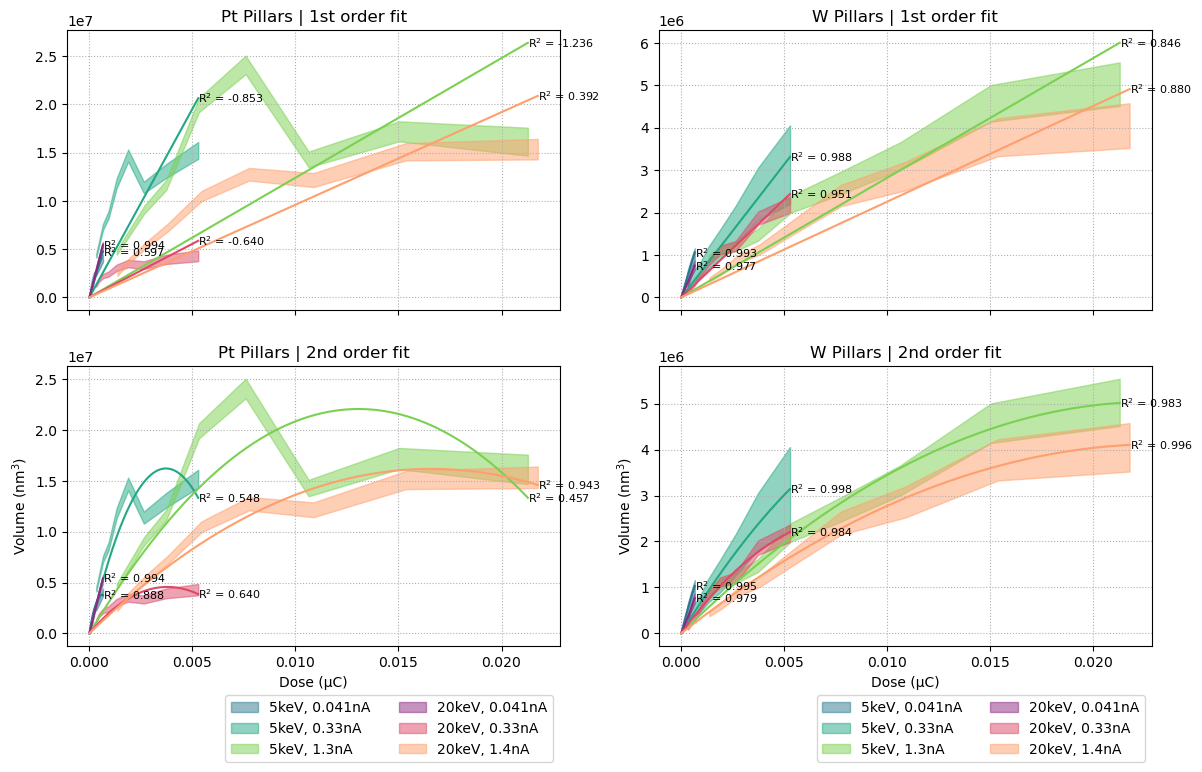

In [13]:
# filter DataFrame
source = df.loc[
    (df["energy (kV)"] < 30) &\
    (df["current (nA)"] < 6) &\
    (df["notes"] != "im, dump")
]

# create figure
ncols = 2
nrows = 2
fig, axes = plt.subplots(
    ncols=ncols,
    nrows=nrows,
    figsize=(7*ncols, 2*4),
    sharex=True,
)

# make crazy color cycler thingy
# | {(W, 5keV): viridis(3 colors),
# |  (W, 20keV): cividis(3 colors) ...}
d_colors = {}
for (material, energy), fns in source.groupby(
    ["material", "energy (kV)"]
)["filename"].unique().to_dict().items():
    cmap = plt.cm.viridis if energy < 10 else plt.cm.magma
    d_colors[(material, energy)] = iter(cmap(
        np.linspace(0.4, 0.8, len(fns))
    ))

# loop through sets of pillars
for i, (fn, grp) in enumerate(source.groupby("filename", sort=False)):

    # extract parameters
    material = grp["material"].iloc[0]
    energy = grp["energy (kV)"].iloc[0]
    current = grp["current (nA)"].iloc[0]
    dumped = True if "dump" in grp["notes"].iloc[0] else False

    # cycle through crazy color thingy
    color = next(d_colors[(material, energy)])

    for n, order in enumerate(["1st", "2nd"]):

        # separate plots by material (one for Pt, one for W)
        ax = axes[n, 0] if material == "Pt" else axes[n, 1]

        # plot error windows
        x = grp["dose (uC)"].values
        y1 = grp["volume (nm^3)"].values - grp["error volume (nm^3)"].values
        y2 = grp["volume (nm^3)"].values + grp["error volume (nm^3)"].values
        ax.fill_between(
            x=x,
            y1=y1,
            y2=y2,
            color=color,
            alpha=0.5,
            label=f"{energy:.0f}keV, {current:.2g}nA"
        )

        # plot polynomial fits
        coeffs = [*d_fits[fn][order]] + [0]
        x_ = np.linspace(0, x.max(), 500)
        y_fit = 1/V0 * np.poly1d(coeffs)(x_)
        ax.plot(
            x_,
            y_fit,
            color=color
        )

        # annotate goodness of fit
        R2 = d_fits[fn]["R^2_1st"] if order == "1st" else d_fits[fn]["R^2_2nd"]
        text = "$\mathregular{R^2}$"
        ax.text(
            x=x_[-1],
            y=y_fit[-1],
            s=text + f" = {R2:.3f}",
            va="center",
            ha="left",
            fontsize=8
        )

        # aesthetics
        title = f"{material} Pillars | {order} order fit"
        ax.set_title(title)
        [ax.grid(ls=":") for ax in axes.flat]

        if n == 1:
            ax.set_xlabel("Dose (µC)")
            ax.set_ylabel("Volume $(\mathregular{nm^3})$")
            ax.legend(bbox_to_anchor=(1, -0.15), ncols=2)

#### Plot Cristiano's desired figure

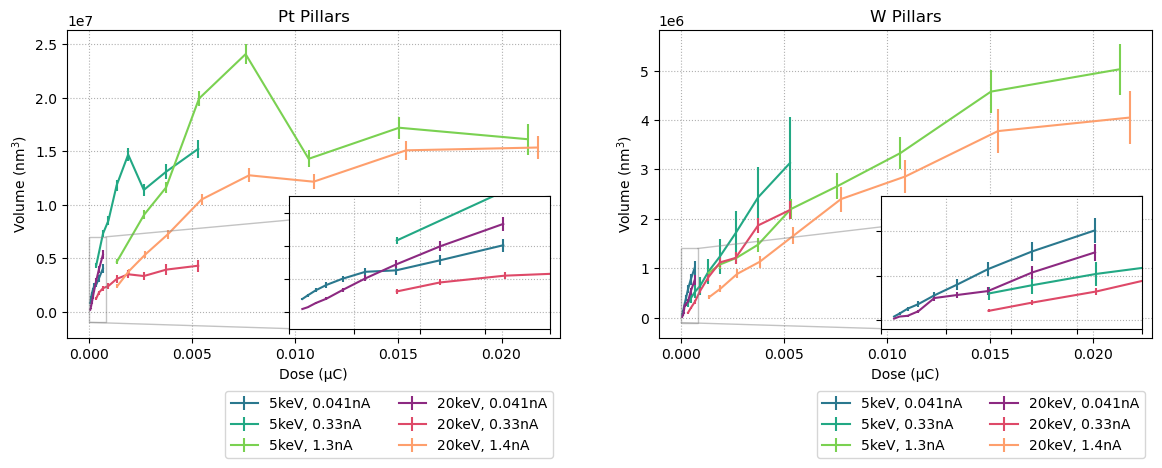

In [14]:
# filter DataFrame
source = df.loc[
    (df["energy (kV)"] < 30) &\
    (df["current (nA)"] < 6) &\
    (df["notes"] != "im, dump")
]

# create figure
ncols = 2
fig, axes = plt.subplots(
    ncols=ncols,
    figsize=(7*ncols, 4),
    sharey=False,
)
# create inset axes
axes_inset = []
for ax in axes:
    ax_in = ax.inset_axes([0.45, 0.03, 0.53, 0.43])
    axes_inset.append(ax_in)

# make crazy color cycler thingy
# | {(W, 5keV): viridis(3 colors),
# |  (W, 20keV): cividis(3 colors) ...}
d_colors = {}
for (material, energy), fns in source.groupby(
    ["material", "energy (kV)"]
)["filename"].unique().to_dict().items():
    cmap = plt.cm.viridis if energy < 10 else plt.cm.magma
    d_colors[(material, energy)] = iter(cmap(
        np.linspace(0.4, 0.8, len(fns))
    ))

# loop through sets of pillars
for i, (fn, grp) in enumerate(source.groupby("filename", sort=False)):

    # extract parameters
    material = grp["material"].iloc[0]
    energy = grp["energy (kV)"].iloc[0]
    current = grp["current (nA)"].iloc[0]
    dumped = True if "dump" in grp["notes"].iloc[0] else False

    # separate plots by material (one for Pt, one for W)
    if material == "Pt":
        ax, ax_in = axes[0], axes_inset[0]
        lims = [0, -1e6, 0.0008, 7e6]
    else:
        ax, ax_in = axes[1], axes_inset[1]
        lims = [0, -1e5, 0.0008, 1.4e6]

    # plot curves with error bars
    color = next(d_colors[(material, energy)])
    ax.errorbar(
        x=grp["dose (uC)"].values,
        y=grp["volume (nm^3)"].values,
        yerr=grp["error volume (nm^3)"].values,
        color=color,
        label=f"{energy:.0f}keV, {current:.2g}nA"
    )

    # plot insets
    ax_in.errorbar(
        x=grp["dose (uC)"].values,
        y=grp["volume (nm^3)"].values,
        yerr=grp["error volume (nm^3)"].values,
        color=color,
        label=f"{energy:.0f}keV, {current:.2g}nA"
    )
    ax_in.set_xlim(lims[0], lims[2])
    ax_in.set_ylim(lims[1], lims[3])
    ax_in.set_xticklabels([])
    ax_in.set_yticklabels([])
    ax_in.grid(ls=":")
    # indicate the inset axis only once for each material
    if i == 0 or (i == 6):
        ax.indicate_inset_zoom(ax_in, edgecolor="#888888")

    # aesthetics
    title = f"{material} Pillars"
    ax.set_title(title)
    ax.set_xlabel("Dose (µC)")
    ax.set_ylabel("Volume $(\mathregular{nm^3})$")
    ax.legend(bbox_to_anchor=(1, -0.15), ncols=2)
    ax.grid(ls=":")

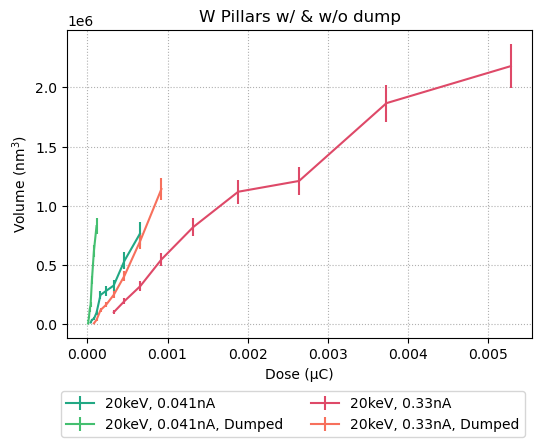

In [71]:
# filter DataFrame
energies = df.loc[df["notes"] == "im, dump"]["energy (kV)"].unique()
source = df.loc[
    (df["material"] == "W") &\
    (df["energy (kV)"].isin(energies)) &\
    (df["current (nA)"] < 1)
]

# create figure
ncols = 1
fig, ax = plt.subplots(
    ncols=ncols,
    figsize=(6*ncols, 4),
    sharey=False,
)

# make crazy color cycler thingy
# | {(W, 5keV): viridis(3 colors),
# |  (W, 20keV): cividis(3 colors) ...}
d_colors = {}
for (current, energy), fns in source.groupby(
    ["current (nA)", "energy (kV)"]
)["filename"].unique().to_dict().items():
    # dumped = True if "dump" in notes else False
    cmap = plt.cm.viridis if current < 0.1 else plt.cm.magma
    d_colors[(current, energy)] = iter(cmap(
        np.linspace(0.6, 0.7, len(fns))
    ))

# loop through sets of pillars
for i, (fn, grp) in enumerate(source.groupby("filename", sort=False)):

    # extract parameters
    material = grp["material"].iloc[0]
    energy = grp["energy (kV)"].iloc[0]
    current = grp["current (nA)"].iloc[0]
    note = grp["notes"].iloc[0]
    dumped = True if "dump" in grp["notes"].iloc[0] else False

    # plot curves with error bars
    color = next(d_colors[(current, energy)])
    label = f"{energy:.0f}keV, {current:.2g}nA"
    if dumped:
        label += ", Dumped"
    ax.errorbar(
        x=grp["dose (uC)"].values,
        y=grp["volume (nm^3)"].values,
        yerr=grp["error volume (nm^3)"].values,
        color=color,
        label=label
    )

    # aesthetics
    title = f"{material} Pillars w/ & w/o dump"
    ax.set_title(title)
    ax.set_xlabel("Dose (µC)")
    ax.set_ylabel("Volume $(\mathregular{nm^3})$")
    ax.legend(bbox_to_anchor=(1, -0.15), ncols=2)
    ax.grid(ls=":")